<a href="https://colab.research.google.com/github/GOWTHAMVANTAKULA/INTELLIGENT-DOCUMENT-ASSISTANT/blob/main/INTELLIGENT_DOCUMENT_ASSISTANT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    -  INTELLIGENT DOCUMENT ASSISTANT

##### **Project Type**    ---    **FULL - STACK AI CHATBOT**
##### **Contribution**    - Individual ---  **VANTAKULA GOWTHAM NAIDU**

# **GitHub Link -**

# **Problem Statement**

In the realm of legal and historical research, professionals often need to extract specific information from large volumes of documents. Manually searching through PDFs can be time-consuming and inefficient. To address this challenge, I developed the Intelligent Document Assistant, a full-stack AI chatbot that leverages Retrieval-Augmented Generation (RAG) and external APIs like Tavily. This assistant enables users to upload PDFs, automatically extract relevant information, and provide accurate answers to user queries, thereby enhancing productivity and efficiency.

### **Project Workflow and Architecture**

1. Environment Setup and Configuration

2. PDF Loading and Processing

3. Text Splitting and Chunking

4. Embedding Generation

5. Vector Store Creation

6. Retriever Initialization

7. RAG Prompt and LLM Setup

8. Fallback Integration with Tavily

9. User Interface Deployment

10. Testing and Validation

11. Production Deployment and Monitoring

# ***Let's Begin !***

### **Environment Setup and Configuration**

In [109]:
import os   # Import the OS module to interact with the operating system
import warnings
warnings.filterwarnings("ignore")

# Set environment variables for API keys and model configurations

os.environ['TAVILY_API_KEY'] = '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'  # Set the Tavily API key
os.environ['LLM_MODEL'] = 'llama-3.3-70b-versatile'  # Specify the LLM model to use
os.environ['LLM_TEMPERATURE'] = '0.7'  # Set the LLM temperature for response variability
os.environ['EMBEDDING_MODEL'] = 'sentence-transformers/all-MiniLM-L6-v2'  # Define the embedding model for text representation
os.environ['CHUNK_SIZE'] = '1000'   # Set the chunk size for text splitting
os.environ['CHUNK_OVERLAP'] = '200'   # Set the overlap size for text splitting
os.environ['LLM_MAX_TOKENS'] = '1024'  # Define the maximum tokens for the LLM output



### **Project Settings Configuration**

In [110]:
from dataclasses import dataclass
import os

@dataclass
class Settings:
    TAVILY_API_KEY: str = os.getenv("TAVILY_API_KEY")
    LLM_MODEL: str = os.getenv("LLM_MODEL")
    LLM_TEMPERATURE: float = float(os.getenv("LLM_TEMPERATURE", "0.7"))
    EMBEDDING_MODEL: str = os.getenv("EMBEDDING_MODEL")
    CHUNK_SIZE: int = int(os.getenv("CHUNK_SIZE", "1000"))
    CHUNK_OVERLAP: int = int(os.getenv("CHUNK_OVERLAP", "200"))
    TOP_K_RESULT: int = int(os.getenv("TOP_K_RESULT", "5"))
    MAX_TOKENS: int = int(os.getenv("LLM_MAX_TOKENS", "2048"))

    def validate(self) -> bool:
        """Check if required API keys are set"""
        if not self.GROQ_API_KEY:
            raise ValueError("Groq API key is not set. Please add it to your env file.")
        if not self.TAVILY_API_KEY:
            raise ValueError("Tavily API key is not set. Please add it to your env file.")
        return True

settings = Settings()


### **Dependency Installation and Setup**

In [ ]:
!pip install -U langchain langchain-community langchain-text-splitters pypdf faiss-cpu sentence-transformers

# Required Libraries:
# - langchain
# - langchain-community
# - langchain-text-splitters
# - pypdf
# - faiss-cpu
# - sentence-transformers



## **Retrieval-Augmented Generation (RAG) Pipeline Implementation**

In [ ]:
# PDF Document Loader Function

from langchain_community.document_loaders import PyPDFLoader

def load_pdf(file_path):
    loader = PyPDFLoader(file_path)
    documents = loader.load()
    return documents

In [ ]:
# Function for Splitting Text into Chunks


from langchain_text_splitters import RecursiveCharacterTextSplitter

def split_text(documents, settings):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=settings.CHUNK_SIZE,
        chunk_overlap=settings.CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    split_chunks = text_splitter.split_documents(documents)
    return split_chunks

**Embedding Generation and Vector Store Creation**

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

In [ ]:
def get_embedding_model(settings):
    embeddings = HuggingFaceEmbeddings(
        model_name=settings.EMBEDDING_MODEL
    )
    return embeddings


In [ ]:
def create_vector_store(chunks, settings):
    embeddings = get_embedding_model(settings)

    vectorstore = FAISS.from_documents(
        documents=chunks,
        embedding=embeddings
    )

    return vectorstore


**Drive Mounting and Document Accessibility**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load PDF
documents = load_pdf("/content/drive/MyDrive/Data_Files/Freedom Movement in India_RAG.pdf")

# Split text
chunks = split_text(documents, settings)

# Create vector store
vectorstore = create_vector_store(chunks, settings)


In [ ]:
# Initialize the retriever with similarity search (top 4 results)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)


**Setting Up the RAG Prompt Template**

In [ ]:
# Set up the retriever for similarity-based document retrieval (top 4 results)

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Create RAG prompt template
rag_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful legal assistant specializing in FREEDOM MOVEMENT IN INDIA. "
        "Answer the question based ONLY on the following context from indian freedom struggle "
        "If the answer is not found in the context, say 'I cannot find this information in the provided documents.'\n\n"
        "Context: {context}"
    ),
    (
        "human",
        "{question}"
    )
])

**LLM Initialization with Groq API**

In [ ]:
!pip install langchain langchain-groq

In [111]:
import os
from getpass import getpass

os.environ["GROQ_API_KEY"] = getpass("Enter your Groq API key: ")


Enter your Groq API key: ··········


In [112]:
from langchain_groq import ChatGroq
rag_llm = ChatGroq(api_key = os.environ["GROQ_API_KEY"],
               model = settings.LLM_MODEL ,
               temperature = settings.LLM_TEMPERATURE,
               max_tokens = settings.MAX_TOKENS,
               max_retries = 2
               )

**Tavily API Integration and Query Handling**

In [113]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize Tavily search with your API key
tavily_search = TavilySearchResults(api_key=settings.TAVILY_API_KEY, max_results=settings.TOP_K_RESULT)

In [ ]:
def tavily_llm(question: str) -> str:
    search_results = tavily_search.invoke({"query": question})
    if not search_results:
        return "No relevant information found from Tavily."

    # Format the content into bullet points within general_llm
    bullet_points = []
    for result in search_results:
        content = result["content"]
        cleaned_content = " ".join(content.split())  # Clean up extra whitespace
        bullet_points.append(f"• {cleaned_content}")

    return "\n".join(bullet_points)

**RAG Chain Construction and Execution**

In [ ]:
# Helper function to format retrieved documents AND CONNECT THE LLM HERE
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
# here we are passing only page content  to the llm not the metadata | for that we defined this function

# Build the RAG chain using LCEL
rag_chain = (
    {
        "context": retriever | format_docs,   # Retrieve and format docs| ALL MY PDF WAS STORED IN RETREVIER
        "question": RunnablePassthrough()     # Pass through the question
    }
    | rag_prompt                              # Create the prompt
    | rag_llm                                     # Generate response
    | StrOutputParser()                       # Parse to string
)

print("✅ RAG chain created")

✅ RAG chain created


**RAG and Tavily Fallback Decision Logic**

In [ ]:
def ask_question(question: str) -> str:
    """
    Uses RAG if answer exists in PDF,
    otherwise falls back to General LLM and indicates the absence of information in the PDF.

    Args:
        question: Your historical question

    Returns:
        str: The answer to the question or a message indicating the information isn't available.
    """
    # Attempt to get the answer from the RAG pipeline
    rag_answer = rag_chain.invoke(question)

    # Check if RAG found the answer
    if rag_answer and "cannot find" not in rag_answer.lower():
        return rag_answer
    else:
        # If RAG didn't find the answer, provide a fallback message and use the general LLM
        message = " xxx--- The question is outside the scope of the provided documents. Here's a general answer: ---XXX "
        general_answer = tavily_llm(question)
        return f"{message.upper()}\n\n{general_answer}"


**End-to-End Query Execution and Testing**

In [ ]:
# Q1
print(ask_question(
    "EXPLAIN INDIAN FREEDOM MOMENTS IN 3-4 POINTS"
))

Based on the provided context, here are 3-4 key points about the Indian Freedom Movement:

1. **Origin of Indian Nationalism**: The concept of nationalism in India developed during the British rule, particularly in the later half of the 19th century, due to factors like Western education, philosophy, and British Imperialism, which unified the country and enabled people to think as one nation.

2. **Role of Key Figures**: Leaders like Netaji Subhas Chandra Bose and Mahatma Gandhi played a significant role in the Indian Freedom Movement. Bose established the Azad Hind Fauj and a Provisional Government of Free India, while Gandhi launched the Civil Disobedient Movement in 1930, which included non-payment of taxes and other forms of protest.

3. **Major Events and Milestones**: The Azad Hind Army fought against the British in Burma, and although they initially achieved success, they were ultimately defeated. Meanwhile, Gandhi's Civil Disobedient Movement led to the presentation of demands 

In [ ]:
# Q2
print(ask_question(
    "why india is named as india.i want answer in 3-4 bullet points"
))

Here are 3-4 bullet points explaining why India is named as India:

* The name "India" is derived from the Sanskrit word "Sindhu", which refers to the Indus River that flows through the northwestern part of the country.
* The ancient Greeks and Romans used the term "Indoi" to refer to the people living beyond the Indus River, which eventually became "India" in English.
* The term "India" was also used by the British colonial rulers to refer to the entire subcontinent, which included present-day India, Pakistan, and Bangladesh.
* The name "India" was officially adopted as the name of the country after it gained independence from British rule in 1947, and it is now used to refer to the Republic of India, a sovereign nation with its own government and constitution.


# **Production-Ready Deployment of the RAG and Tavily Pipeline**

In [ ]:

!pip -q install streamlit pyngrok

In [ ]:
%%writefile app.py
import streamlit as st
import os
import io # Import io for BytesIO
import tempfile # Import tempfile for creating temporary files
from dataclasses import dataclass

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults


@dataclass
class Settings:
    GROQ_API_KEY: str = os.getenv("GROQ_API_KEY")
    TAVILY_API_KEY: str = os.getenv("TAVILY_API_KEY")
    LLM_MODEL: str = os.getenv("LLM_MODEL")
    LLM_TEMPERATURE: float = float(os.getenv("LLM_TEMPERATURE", "0.7"))
    EMBEDDING_MODEL: str = os.getenv("EMBEDDING_MODEL")
    CHUNK_SIZE: int = int(os.getenv("CHUNK_SIZE", "1000"))
    CHUNK_OVERLAP: int = int(os.getenv("CHUNK_OVERLAP", "200"))
    FAST_INDEX_PATH: str = os.getenv("FAST_INDEX_PATH")
    TOP_K_RESULT: int = int(os.getenv("TOP_K_RESULT", "5"))
    MAX_TOKENS: int = int(os.getenv("LLM_MAX_TOKENS", "2048"))

    def validate(self) -> bool:
        """Check if required API keys are set"""
        if not self.GROQ_API_KEY:
            raise ValueError("Groq API key is not set. Please add it to your env file.")
        if not self.TAVILY_API_KEY:
            raise ValueError("Tavily API key is not set. Please add it to your env file.")
        return True

settings = Settings()

# Define the RAG prompt template within app.py
rag_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful legal assistant specializing in FREEDOM MOVEMENT IN INDIA. "
        "Answer the question based ONLY on the following context from indian freedom struggle "
        "If the answer is not found in the context, say 'I cannot find this information in the provided documents.'\n\n"
        "Context: {context}"
    ),
    (
        "human",
        "{question}"
    )
])

# 1. PDF Loading
# Modified to accept a file-like object from Streamlit uploader
def load_pdf(uploaded_file):
    # Create a temporary file to save the uploaded PDF
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as tmp_file:
        tmp_file.write(uploaded_file.getvalue())
        tmp_file_path = tmp_file.name

    loader = PyPDFLoader(tmp_file_path)
    documents = loader.load()

    # Clean up the temporary file
    os.remove(tmp_file_path)
    return documents

# 2. Text Splitting
def split_text(documents, settings):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=settings.CHUNK_SIZE,
        chunk_overlap=settings.CHUNK_OVERLAP,
        length_function=len,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    split_chunks = text_splitter.split_documents(documents)
    return split_chunks

# Create Embedding Model (using Settings)
def get_embedding_model(settings):
    embeddings = HuggingFaceEmbeddings(
        model_name=settings.EMBEDDING_MODEL
    )
    return embeddings

# Step 3: Create Vector Store (FAISS)
def create_vector_store(chunks, settings):
    embeddings = get_embedding_model(settings)

    vectorstore = FAISS.from_documents(
        documents=chunks,
        embedding=embeddings
    )

    return vectorstore

# Initialize Tavily search with your API key
tavily_search = TavilySearchResults(api_key=settings.TAVILY_API_KEY, max_results=settings.TOP_K_RESULT)

def tavily_llm(question: str) -> str:
    search_results = tavily_search.invoke({"query": question})
    if not search_results:
        return "No relevant information found from Tavily."

    bullet_points = []
    for result in search_results:
        content = result["content"]
        cleaned_content = " ".join(content.split())  # Clean up extra whitespace
        bullet_points.append(f"\u2022 {cleaned_content}")

    return "\n".join(bullet_points)

st.title('INTELLIGENT DOCUMENT ASSISTANT')

uploaded_file = st.file_uploader("Upload a PDF document", type=["pdf"])

retriever = None # Initialize retriever to None

if uploaded_file is not None:
    with st.spinner("Processing PDF..."):
        try:
            documents = load_pdf(uploaded_file)
            chunks = split_text(documents, settings)
            vectorstore = create_vector_store(chunks, settings)
            retriever = vectorstore.as_retriever(
                search_type="similarity",
                search_kwargs={"k": 4}
            )
            st.success("PDF processed successfully!")
        except Exception as e:
            st.error(f"Error processing PDF: {e}. Please ensure it's a valid PDF.")

# LLM Setup (moved outside the if block so it's always available for Tavily fallback)
rag_llm = ChatGroq(api_key = settings.GROQ_API_KEY,
                   model = settings.LLM_MODEL ,
                   temperature = settings.LLM_TEMPERATURE,
                   max_tokens = settings.MAX_TOKENS,
                   max_retries = 2
                   )

# Helper function to format retrieved documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Build the RAG chain using LCEL - now conditional on retriever availability
rag_chain = None # Initialize rag_chain
if retriever is not None:
    rag_chain = (
        {
            "context": retriever | format_docs,
            "question": RunnablePassthrough()
        }
        | rag_prompt
        | rag_llm
        | StrOutputParser()
    )

def ask_question(question: str) -> str:
    """
    Uses RAG if answer exists in PDF,
    otherwise falls back to General LLM and indicates the absence of information in the PDF.

    Args:
        question: Your historical question

    Returns:
        str: The answer to the question or a message indicating the information isn't available.
    """
    if rag_chain is not None: # Only use RAG if a PDF was successfully processed
        rag_answer = rag_chain.invoke(question)

        if rag_answer and "cannot find" not in rag_answer.lower():
            return rag_answer

    # If no PDF processed, or RAG didn't find the answer, fall back to general LLM
    message = " xxx--- The question is outside the scope of the provided documents. Here's a general answer: ---XXX "
    general_answer = tavily_llm(question)
    return f"{message.upper()}\n\n{general_answer}"


question = st.text_area("Ask your question:")

if st.button("Get Answer"):
    if question.strip():
        if uploaded_file is None: # Warn if no file uploaded but user tries to ask a question
            st.warning("Please upload a PDF document first to use RAG, or proceed for a general answer.")
        with st.spinner("Thinking..."):
            ans = ask_question(question)
        st.markdown(ans)
    else:
        st.warning("Please enter a question.")

Overwriting app.py


**Streamlit App Deployment and Public URL Generation**

In [ ]:
import subprocess, time
from pyngrok import ngrok
import warnings
warnings.filterwarnings("ignore")

# Terminate any existing ngrok processes to prevent 'endpoint already online' errors
ngrok.kill()

# Set your ngrok auth token here
ngrok.set_auth_token("37gqp2jcGZ9bseERVMkYQa1WtY1_4yHBtVmAommQe73gcHB5A")

# Terminate any existing Streamlit process before starting a new one
# This tries to be robust by killing any process listening on port 8501
!kill $(lsof -t -i:8501)

# Start Streamlit in the background
process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0"])
time.sleep(5)  # Give Streamlit some time to start

# Establish ngrok tunnel and print the public URL
try:
    public_url = ngrok.connect(8501)
    print("Your Streamlit app is live at:", public_url)
except Exception as e:
    print(f"Error establishing ngrok tunnel: {e}")
    if process.poll() is None: # If Streamlit process is still running, terminate it
        process.terminate()
        process.wait()

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Your Streamlit app is live at: NgrokTunnel: "https://phenomenalistic-sumptuously-amira.ngrok-free.dev" -> "http://localhost:8501"


**"Streamlit_App_Live_Demo.png"**

This image displays the live deployment of the Intelligent Document Assistant, highlighting the fully functional user interface and the accessible public URL for seamless interaction.

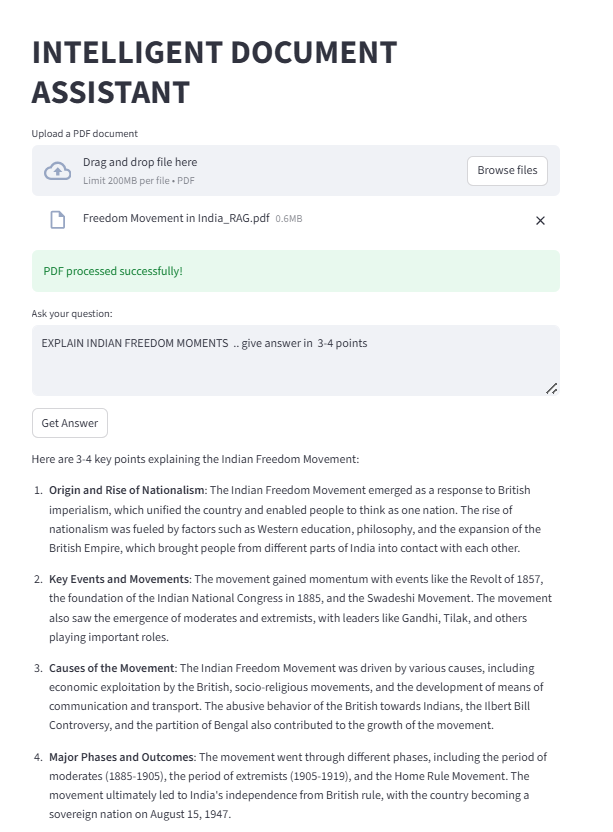

 **CONCLUSION**

This project implements an **Intelligent Document Assistant**, a versatile RAG (Retrieval-Augmented Generation) system designed to answer questions based on various PDF documents.

**Key Features:**

*   **Dynamic PDF Upload:** Users can upload any PDF document via a Streamlit interface.
*   **Automated Document Processing:** Uploaded PDFs are automatically loaded, split into manageable chunks, and converted into a searchable vector store (using FAISS and HuggingFace Embeddings).
*   **Contextual Question Answering (RAG):** The system uses a Groq-powered LLM (Large Language Model) to answer questions, first attempting to retrieve relevant information *only* from the uploaded PDF document.
*   **General Knowledge Fallback:** If the answer is not found within the provided PDF context, the system intelligently falls back to a general web search (using Tavily API) to provide an answer, indicating that the information was outside the scope of the document.
*   **Streamlined User Experience:** A user-friendly Streamlit application provides an intuitive interface for document upload and question-answering.